# LSTM AutoEncoder (LSTM-AE) tutorial
본 tutorial은 `scratch를 통한 LSTM-AE 구현 및 LSTM 인코더를 활용한 예측`을 목표로 하며, 이를 위해 다음과 같은 순서로 진행된다.
1. 데이터 불러오기 및 EDA
2. 인코더와 디코더 정의
3. 학습 및 결과 확인
4. 인코더의 latent vector에 대한 t-SNE를 통해 특징 확인
5. 인코더 구조를 활용한 multi-step forecasting

-----
코드 구현 결과에 대한 해석은 다음과 같다.


In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
import torch.nn.functional as F
import arff2pandas as a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
rcParams['figure.figsize'] = 12, 8
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
"""데이터 불러오기"""
with open('data/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('data/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

5000개의 샘플, 각 변수는 한 명의 심장 박동수를 기록한 것

In [3]:
## 데이터 수 증가를 위해 합치기
df = train.append(test)
df = df.sample(frac=1.0) # 복원 추출
df.shape

(5000, 141)

In [4]:
## 데이터 클래스 정의
    # 심작박동에 대한 정의 5가지
    # 5000개의 행은 단일 심작박동 기록을 나타낸다.
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

In [5]:
## 마지막 열의 이름 변경
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## EDA

In [6]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [9]:
# 각 클래스의 평균 패턴 확인
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=3, color = 'darkslateblue')
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.3
    )
    ax.set_title(class_name)

Normal 클래스는 다른 target값과 다른 패턴을 가지고 있다.

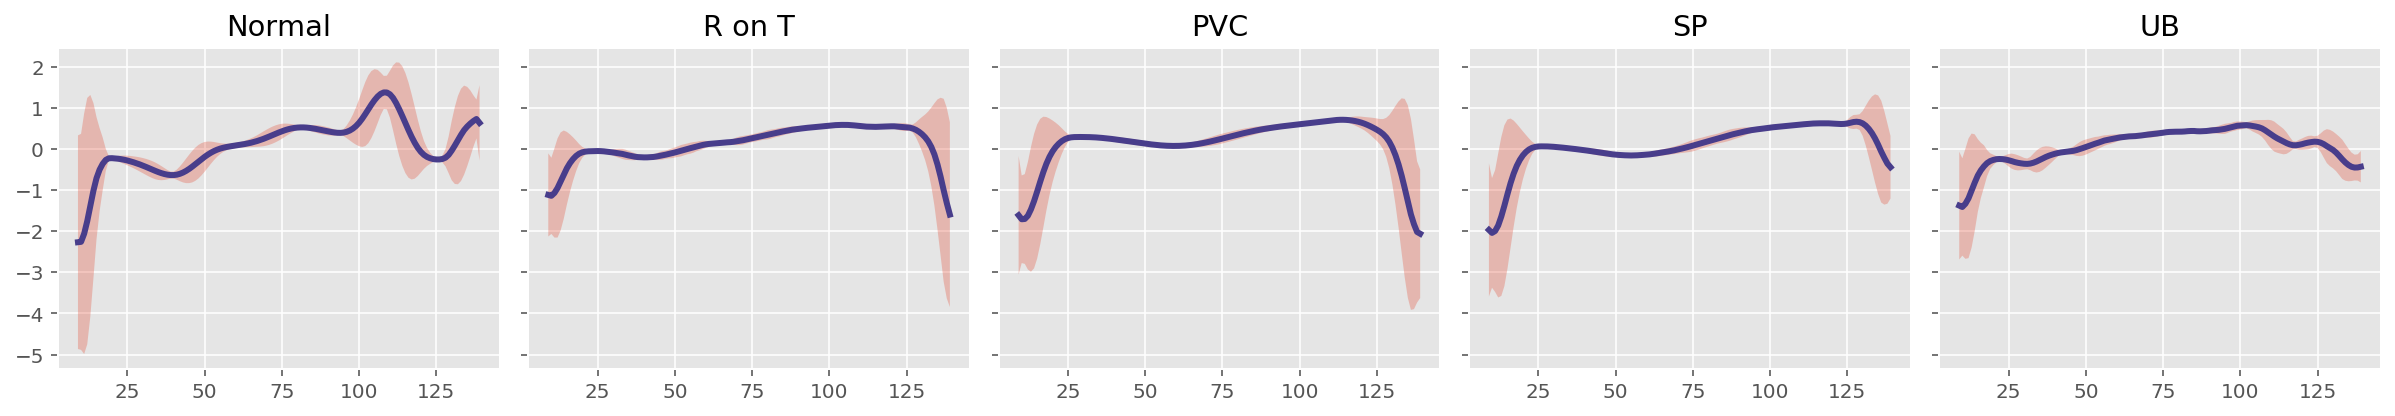

In [10]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=1,
  ncols=6,
  sharey=True,
  figsize=(20, 3)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

### 모델 정의
- Normal 클래스의 심장 박동을 모델의 훈련 데이터로 사용하고, reconstruction loss를 기록

In [11]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
print('정상 target 데이터 :', normal_df.shape)

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print('이상 target 데이터 :', anomaly_df.shape)

정상 target 데이터 : (2919, 140)
이상 target 데이터 : (2081, 140)


In [12]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=seed
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=seed
)

In [13]:
"""dataset과 seq_len, n_features를 만들고 텐서로 변환하는 함수 만들기"""
    # [length, n_features]
def create_dataset(df):
    sequences = df.astype(np.float32).tolist() # 한 관측치의 모든 변수가 시퀀스가 됨
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences] # 차원 변경
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [14]:
train_df.shape

(2481, 140)

In [15]:
"""scaling"""
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
train_df = mms.fit_transform(train_df)
val_df = mms.transform(val_df)
test_df = mms.transform(test_df)
anomaly_df = mms.transform(anomaly_df)

In [16]:
## train, valid, test 데이터에 적용
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [17]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64) # batch별로 나누기
valid_loader = DataLoader(val_dataset, batch_size=64)
test_normal_loader = DataLoader(test_normal_dataset, batch_size=64)
test_abnormal_loader = DataLoader(test_anomaly_dataset, batch_size=64)

## LSTM-AE의 인코더

#### - 인코더 하나씩 구성하기

In [18]:
"""하나의 입력 sequence"""
for seq_true in train_loader:
    input_first = seq_true
    break
print('첫 번째 인코더 input sequence shape :', input_first.shape)

첫 번째 인코더 input sequence shape : torch.Size([64, 140, 1])


In [19]:
"""두 개의 lstm 레이어"""
# shape을 변경하여 batch_first로 하기
n_features = 1
self_embedding_dim = 128
self_hidden_dim = self_embedding_dim * 2

self_LSTM1 = nn.LSTM(input_size=n_features, hidden_size=self_hidden_dim, num_layers=1, batch_first=True)
self_LSTM2 = nn.LSTM(input_size=self_hidden_dim, hidden_size=self_embedding_dim, num_layers=1, batch_first=True)

## 입력 형태에 맞게 변환
self_seq_len = seq_len
self_n_features = n_features
input_first = input_first.reshape((-1, self_seq_len, self_n_features))
print('LSTM에 입력되는 형태 :', input_first.shape)

LSTM에 입력되는 형태 : torch.Size([64, 140, 1])


In [20]:
## lstm 적용
first_output, (_, _) = self_LSTM1(input_first)
second_output, (hidden_n, _) = self_LSTM2(first_output)
print('인코더 최종 output 형태 :', second_output.shape)
print('인코더 최종 hidden 형태 :', hidden_n.shape) # 마지막 값만 가져오기
print('인코더 hidden reshape :', hidden_n.reshape((-1, self_n_features, self_embedding_dim)).shape)
hidden_n = hidden_n.reshape((-1, self_n_features, self_embedding_dim))

인코더 최종 output 형태 : torch.Size([64, 140, 128])
인코더 최종 hidden 형태 : torch.Size([1, 64, 128])
인코더 hidden reshape : torch.Size([64, 1, 128])


- 최종 인코더 구조

In [21]:
"""레이어가 두 개로 구성된 인코더 만들기"""
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim # hidden 차원의 수는 임베딩 차원의 두 배로 구성

    # 각 lstm 레이어는 한 개로 설정
    self.LSTM1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.LSTM2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  
  def forward(self, x):
    x = x.reshape((-1, self_seq_len, self_n_features))

    x, (_, _) = self.LSTM1(x)
    x, (hidden_n, _) = self.LSTM2(x)

    return hidden_n.reshape((-1, self_n_features, self_embedding_dim))

## LSTM-AE의 디코더

#### - 디코더 하나씩 구성하기

In [22]:
"""두 개의 lstm 레이어"""
# shape을 변경하여 batch_first로 하기
n_features = 1
self_input_dim = self_embedding_dim
self_hidden_dim = self_input_dim * 2

self_de_LSTM1 = nn.LSTM(input_size=self_input_dim, hidden_size=self_input_dim, num_layers=1, batch_first=True) # 64->64
self_de_LSTM2 = nn.LSTM(input_size=self_input_dim, hidden_size=self_hidden_dim, num_layers=1, batch_first=True) # 64->128
self_output_layer = nn.Linear(self_hidden_dim, n_features) # 128->1 

In [23]:
print(hidden_n.shape)
hidden_n = hidden_n.repeat(1, self_seq_len, self_n_features)
print('repeat한 hidden 형태:', hidden_n.shape)
# hidden_n = hidden_n.reshape((self_n_features, self_seq_len, self_input_dim))
print('디코더 입력 형태:', hidden_n.shape)

torch.Size([64, 1, 128])
repeat한 hidden 형태: torch.Size([64, 140, 128])
디코더 입력 형태: torch.Size([64, 140, 128])


In [24]:
## lstm 적용
first_output, (hidden_n, cell_n) = self_de_LSTM1(hidden_n) # 인코더 결과가 input
print('디코더 첫번째 LSTM output 형태 :', first_output.shape)
second_output, (hidden_n, cell_n) = self_de_LSTM2(first_output)
print('디코더 마지막 LSTM output 형태 :', second_output.shape)
print('디코더 마지막 LSTM hidden 형태 :', hidden_n.shape) # 마지막 값만 가져오기
print()

final_input = second_output.reshape((-1, self_seq_len, self_hidden_dim))
print('최종 linear layer input 형태 :', final_input.shape)
final_output = self_output_layer(second_output)
print('최종 output shape :', final_output.shape)

디코더 첫번째 LSTM output 형태 : torch.Size([64, 140, 128])
디코더 마지막 LSTM output 형태 : torch.Size([64, 140, 256])
디코더 마지막 LSTM hidden 형태 : torch.Size([1, 64, 256])

최종 linear layer input 형태 : torch.Size([64, 140, 256])
최종 output shape : torch.Size([64, 140, 1])


- 최종 디코더 구조

In [25]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.LSTM1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.LSTM2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, self.n_features)
    # x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.LSTM1(x)
    x, (hidden_n, cell_n) = self.LSTM2(x)
    # x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

## 최종 형태
- 위에서 만든 인코더와 디코더 Class를 가져와서 하나의 Class로 만들기
- 인코더의 output이 디코더의 input으로 들어가도록 설정

In [26]:
class LSTM_AE(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(LSTM_AE, self).__init__()
    # 인코더와 디코더 정의
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
  
  ## 인코더의 output을 빼기 위한 구조
  def get_encoder_outputs(self, x):
    return self.encoder(x)

In [27]:
model = LSTM_AE(seq_len, n_features, embedding_dim=128)
model = model.to(device)

### 모델 학습

In [28]:
"""model train 함수
- 매 epoch 마다 valid set 검증
- dictionary 형태로 train과 valid의 loss를 계산"""
def train_model(model, data_loader, valid_loader, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in data_loader:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in valid_loader:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        # epoch별 train & valid loss의 평균
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        if epoch%20==0:
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [29]:
model, history = train_model(model, train_loader, valid_loader, n_epochs=200)

Epoch 20: train loss 220.99197896321616 val loss 189.12621154785157
Epoch 40: train loss 147.79700880784256 val loss 133.132958984375
Epoch 60: train loss 148.531616797814 val loss 132.7413772583008
Epoch 80: train loss 122.35482201209435 val loss 108.13824462890625
Epoch 100: train loss 111.31311876345903 val loss 99.47064666748047
Epoch 120: train loss 91.59391295604216 val loss 80.35580902099609
Epoch 140: train loss 47.28622416960887 val loss 40.73933563232422
Epoch 160: train loss 27.12064043680827 val loss 20.08862895965576
Epoch 180: train loss 17.073925287295612 val loss 15.062202644348144
Epoch 200: train loss 13.205379168192545 val loss 10.01764268875122


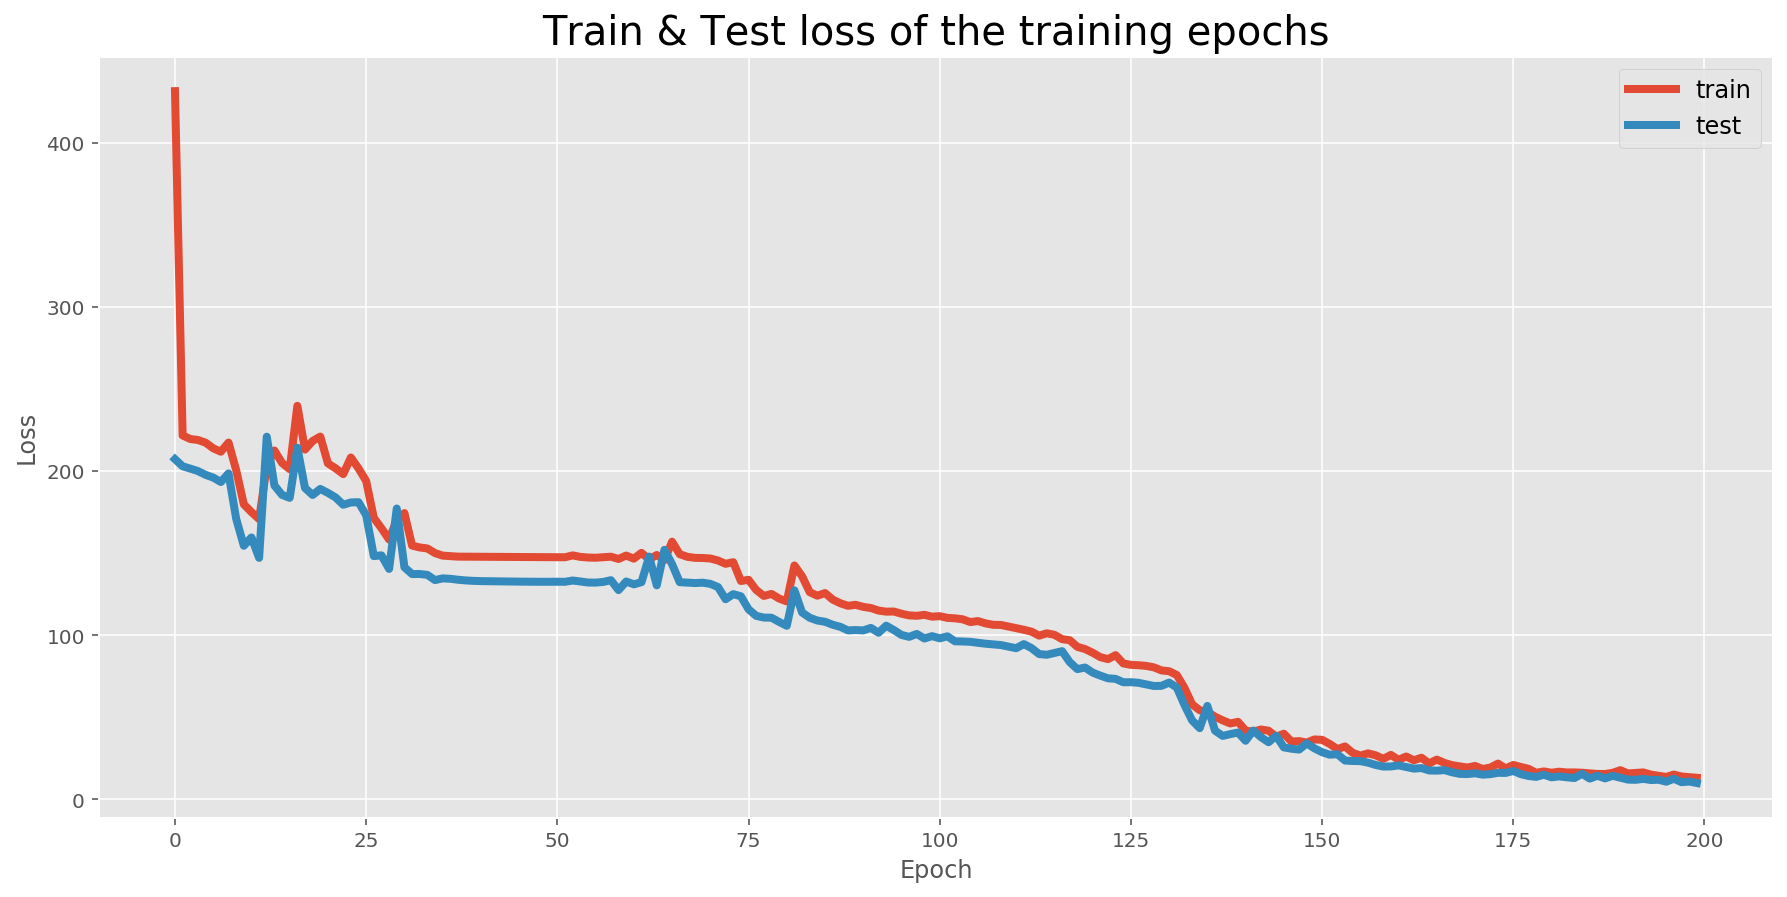

In [30]:
ax = plt.figure(figsize = (15, 7)).gca()
ax.plot(history['train'], linewidth = 4)
ax.plot(history['val'], linewidth = 4)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], fontsize = 12)
plt.title('Train & Test loss of the training epochs', fontsize = 20)
plt.show();

In [31]:
"""파라미터 저장"""
MODEL_PATH = 'LSTM_AE_parameter.pth'

torch.save(model, MODEL_PATH)
# model.load_state_dict(torch.load('LSTM_AE_parameter.pth'))

### 임계값 설정
- Train dataset에 대한 reconstruction error를 확인한다.
- LSTM_AE class에서 predict 부분만 가져오기

In [32]:
"""train or valid or test dataset에 대해서 예측 및 loss 함수 구성"""
# 역전파가 이루어지는 부분이 없도록 구성
def Calculate_RPL(model, dataset):
  real, predictions, losses = [], [], []
  criterion = nn.MSELoss(reduction='sum').to(device) # 손실함수 L1으로 설정
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred.squeeze(0), seq_true)

      real.append(mms.inverse_transform(seq_true.cpu().numpy().reshape(1,-1))) # 실제값
      predictions.append(mms.inverse_transform(seq_pred.cpu().numpy().reshape(1,-1))) # 예측값
      losses.append(loss.item()) # loss
  return real, predictions, losses

2481개의 train dataset에 대해서 loss를 계산해본다.
또한 개별 관측치 (140의 sequence)에 대해서 얼마나 복원을 잘 했는지 확인한다.

In [33]:
"""train dataset에 대한 결과 확인"""
Real, Pred, losses = Calculate_RPL(model, train_dataset)

15개의 정상 심박수 패턴에 대한 복원을 수행한 결과는 아래와 같다. 대부분에 있어서 잘 복원을 한 것을 알 수 있다.

[]

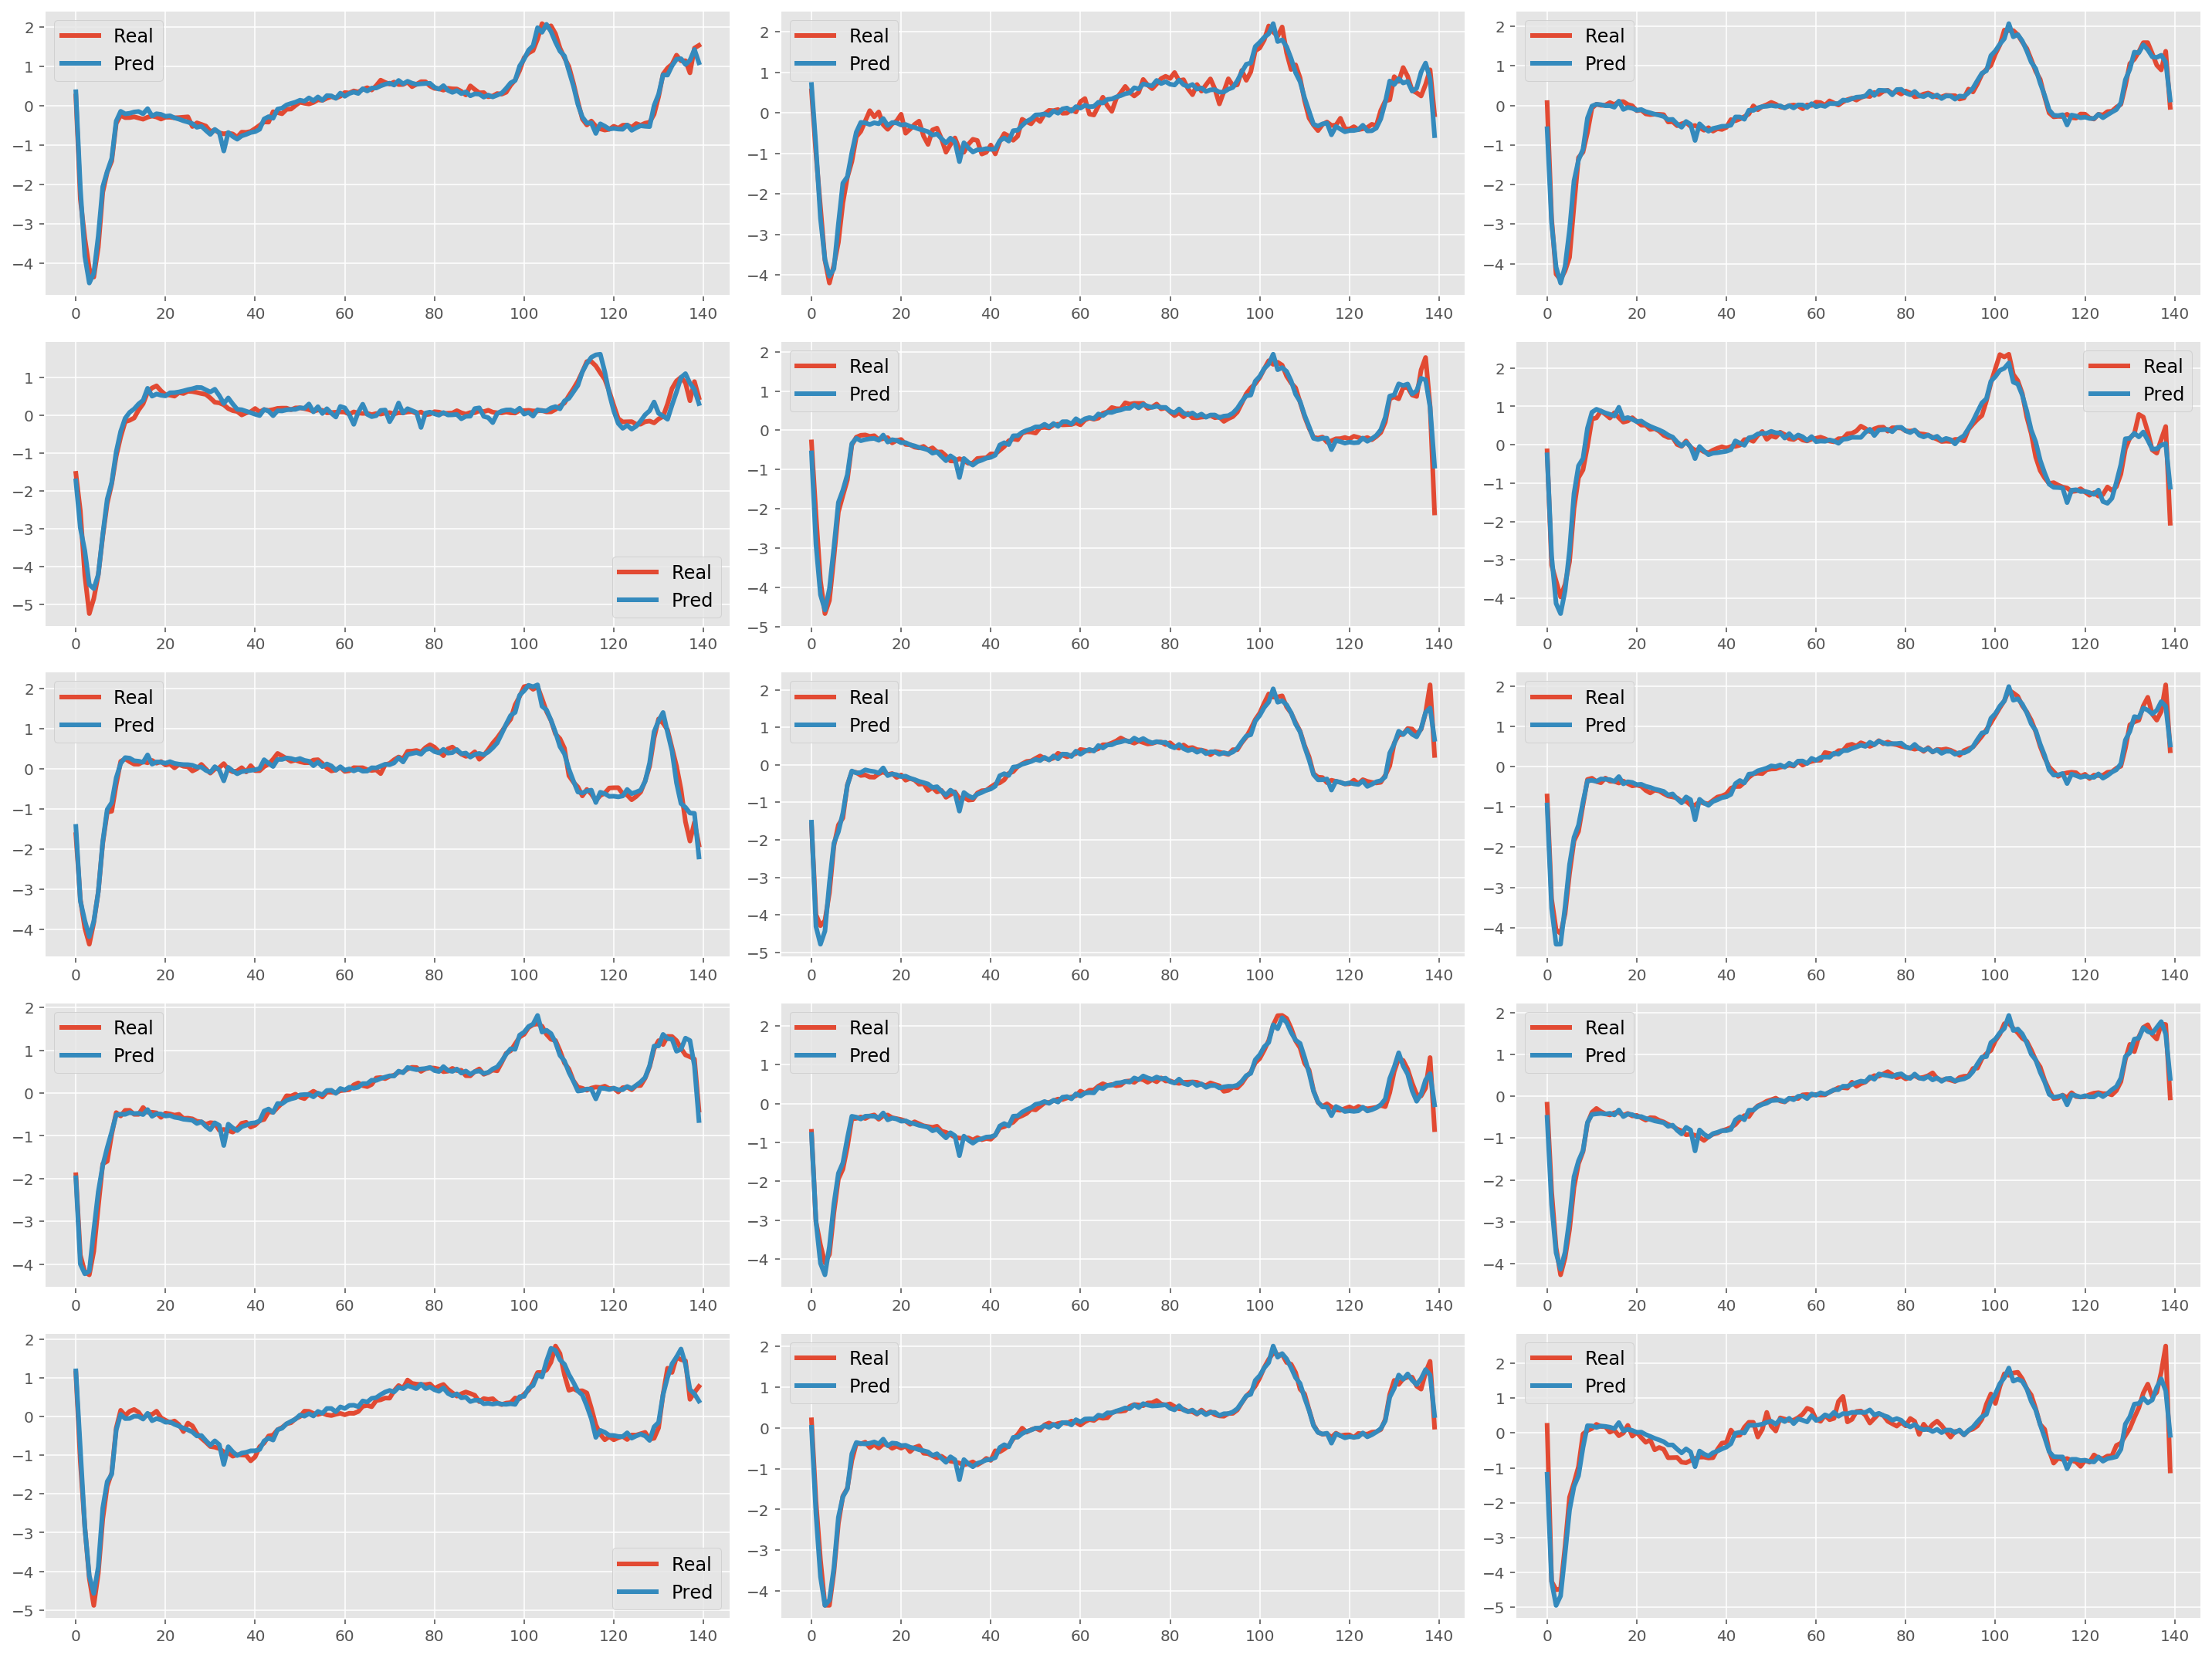

In [34]:
"""복원 값 확인하기"""
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=5)   # 그래프를 5x3으로 배열합니다.

axes = ax.ravel()              # 5 x 3 으로 생성된 subplot을 1 x 15로 변환해 줍니다.
for idx in range(15):            # column의 순서와 이름을 동시에 가지고 옵니다.
    axes[idx].plot(Real[idx].flatten(), linewidth=3)  # scatter plot을 그립니다.
    axes[idx].plot(Pred[idx].flatten(), linewidth=3)  # x label에 feature 이름을 넣어줍니다.
    axes[idx].legend(['Real', 'Pred'], fontsize = 12)
plt.tight_layout() 
plt.plot()

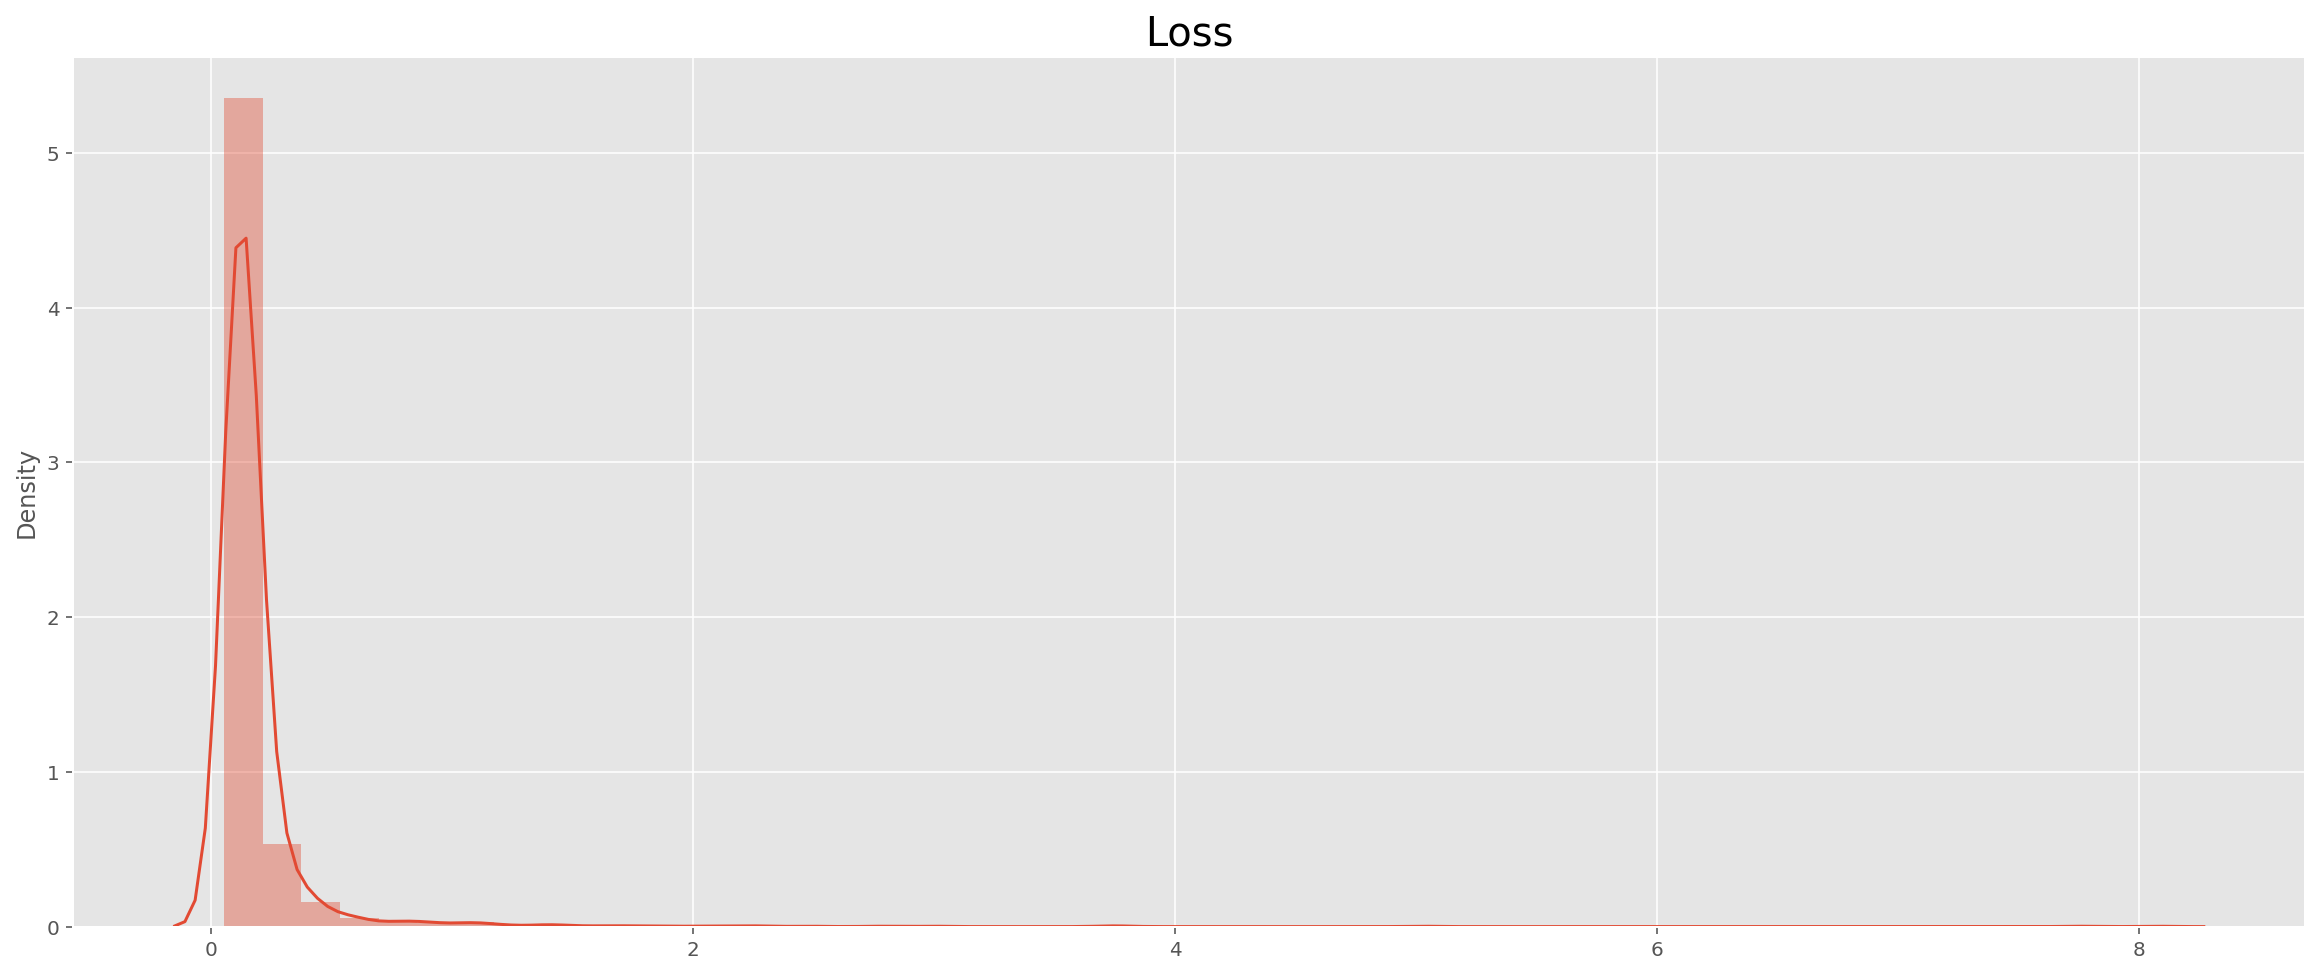

In [35]:
"""임계값 찾기"""
plt.figure(figsize = (20,8))
sns.distplot(losses, bins=50, kde=True);
plt.title('Loss', fontsize = 20)
plt.show()

임계값을 20으로 설정

In [36]:
threshold = 1

"""test dataset에 대한 결과 확인"""
Real_test_normal, Pred_test_normal, losses_test_normal = Calculate_RPL(model, test_normal_dataset)

[]

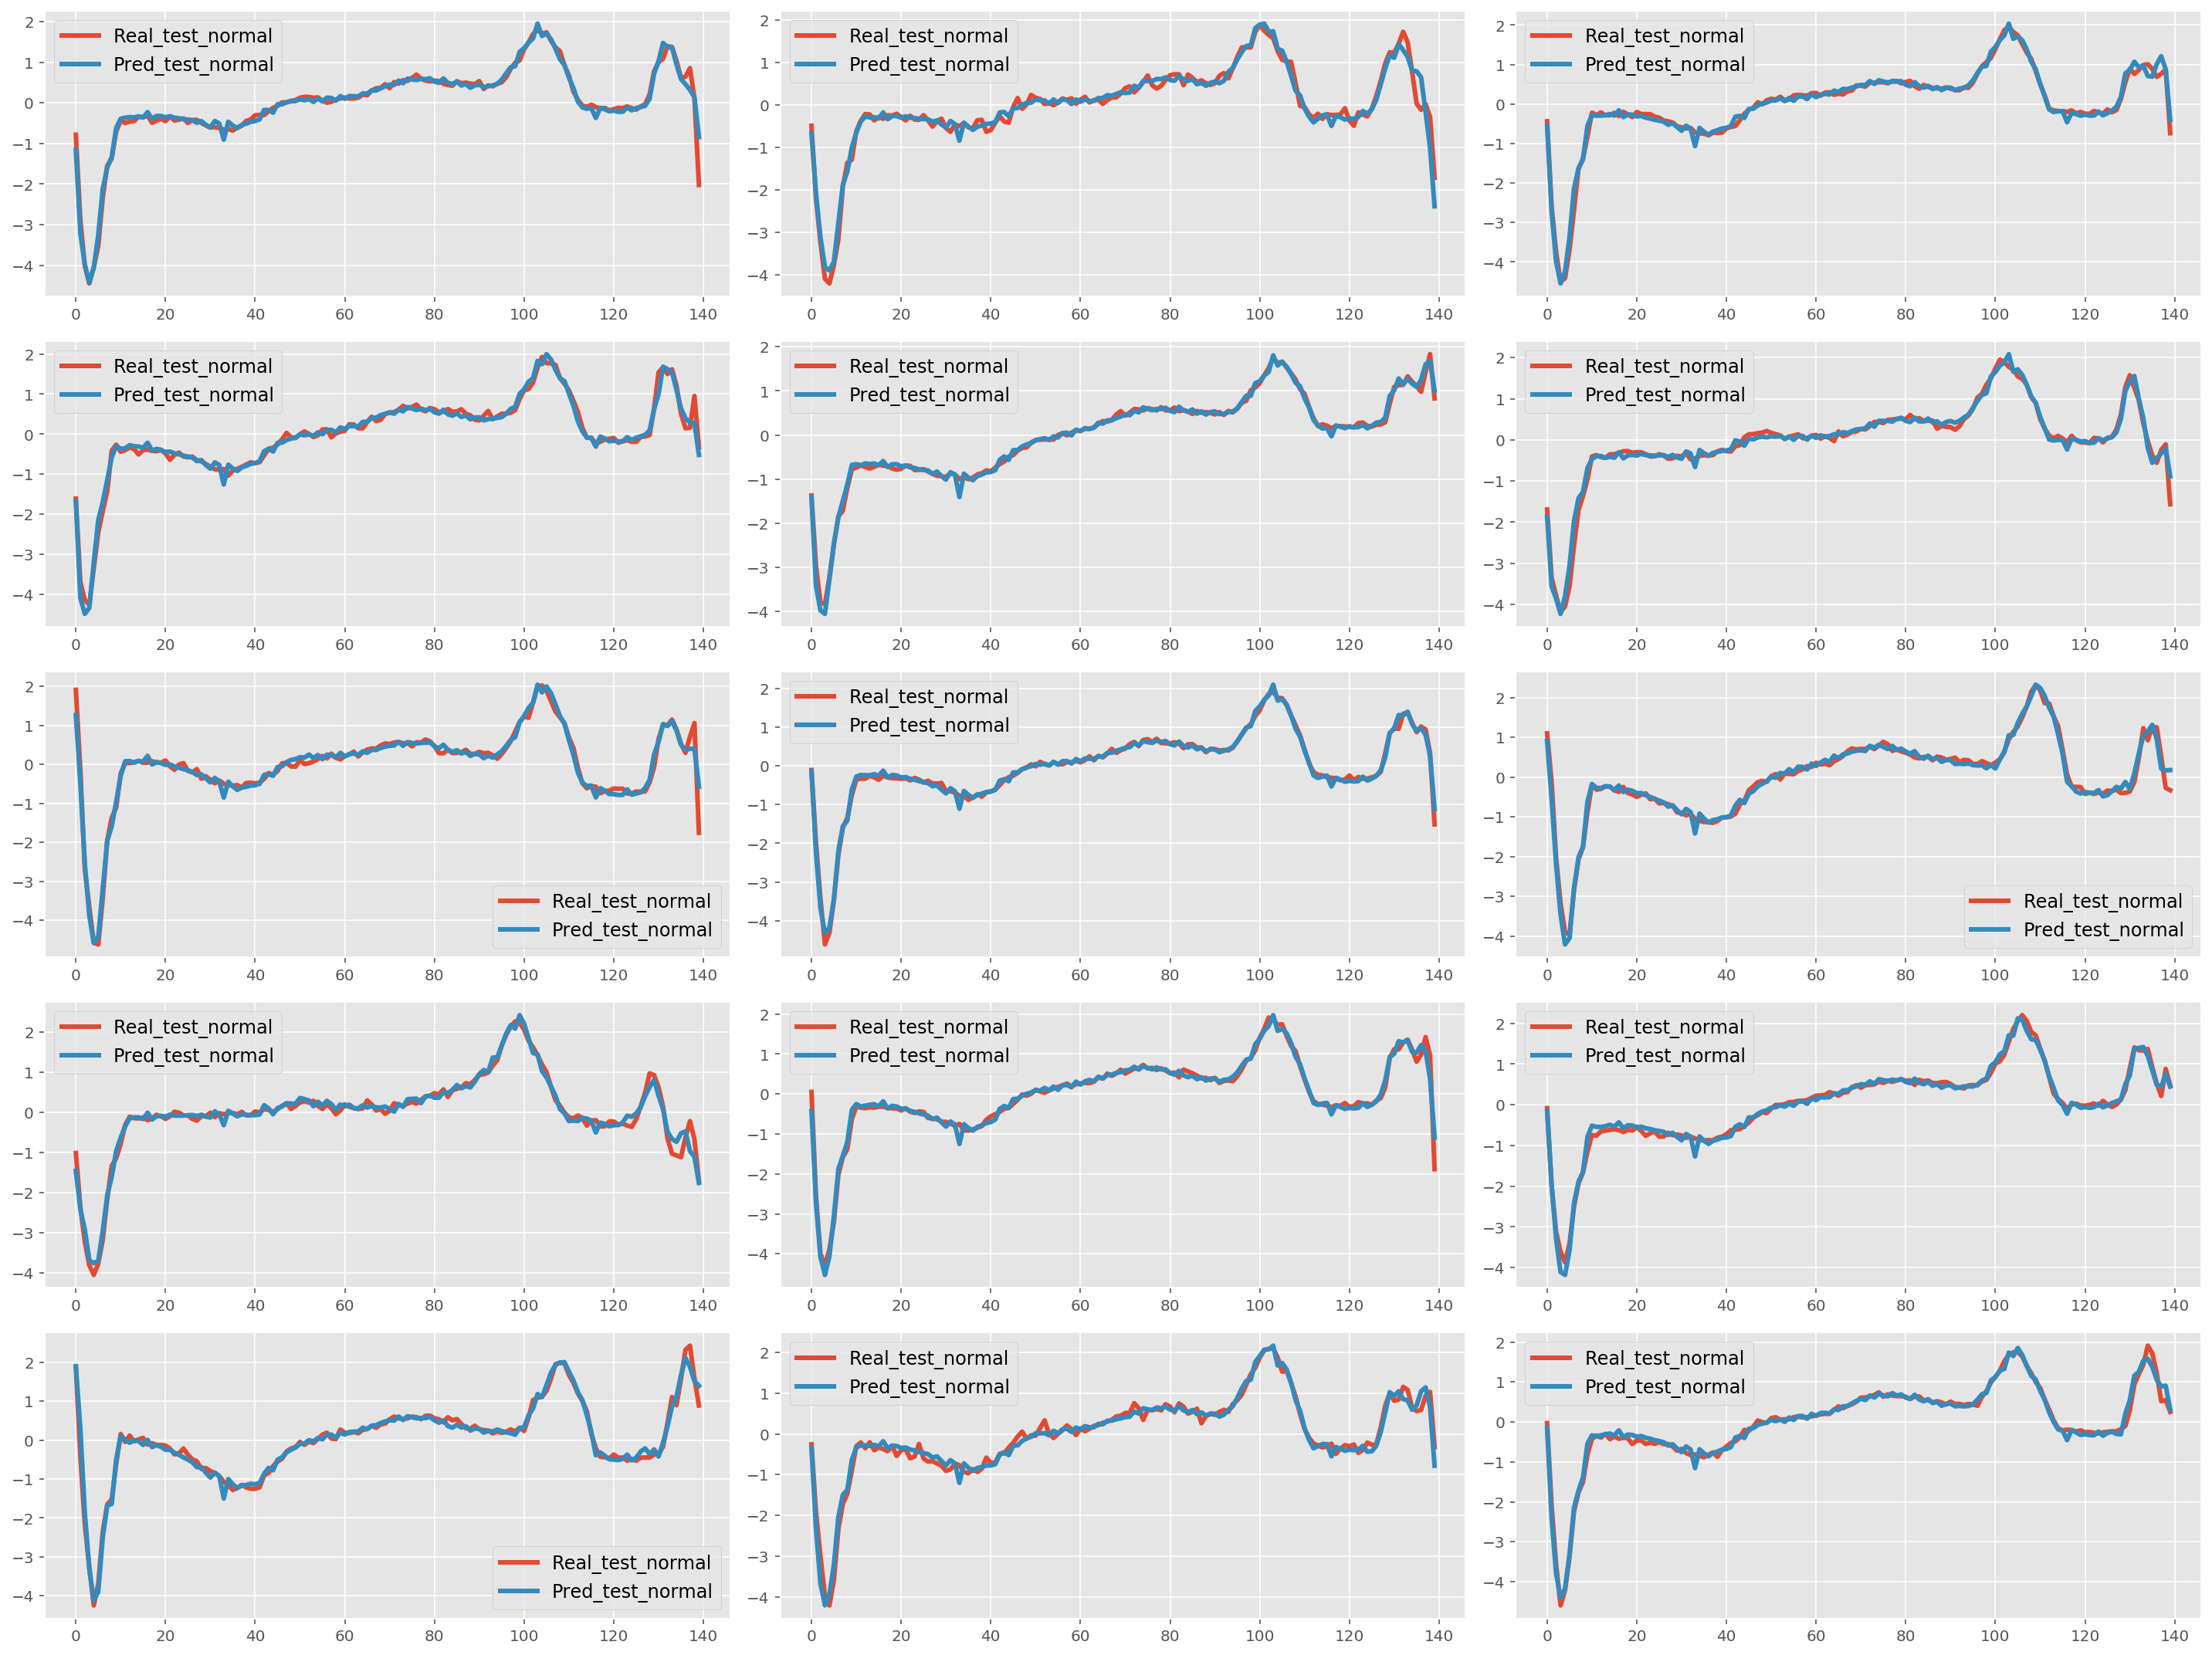

In [37]:
"""복원 값 확인하기"""
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=5)   # 그래프를 5x3으로 배열합니다.

axes = ax.ravel()              # 5 x 3 으로 생성된 subplot을 1 x 15로 변환해 줍니다.
for idx in range(15):            # column의 순서와 이름을 동시에 가지고 옵니다.
    axes[idx].plot(Real_test_normal[idx].flatten(), linewidth=3)  # scatter plot을 그립니다.
    axes[idx].plot(Pred_test_normal[idx].flatten(), linewidth=3)  # x label에 feature 이름을 넣어줍니다.
    axes[idx].legend(['Real_test_normal', 'Pred_test_normal'], fontsize = 12)
plt.tight_layout() 
plt.plot()

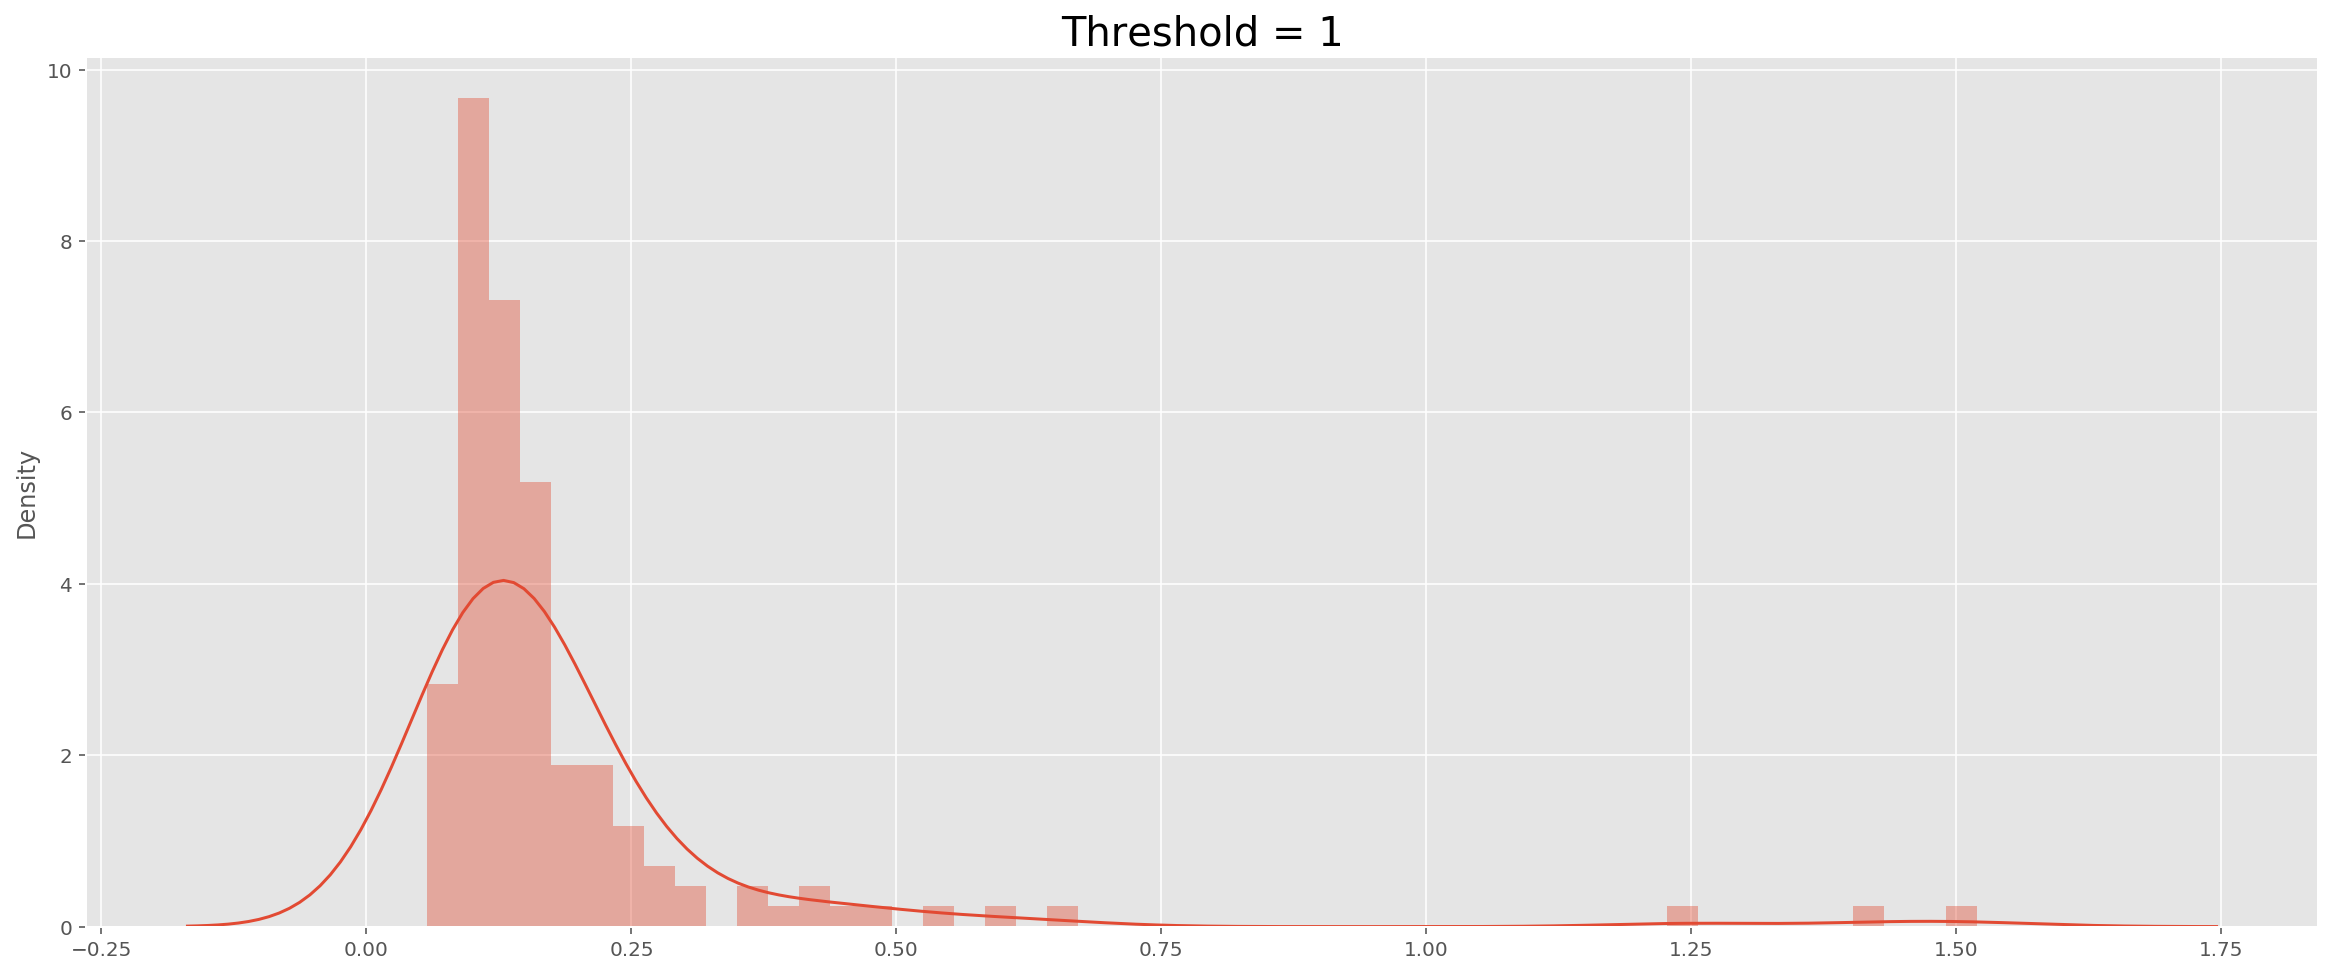

In [38]:
"""임계값 찾기"""
plt.figure(figsize = (20,8))
sns.distplot(losses_test_normal, bins=50, kde=True);
plt.title(f'Threshold = {threshold}', fontsize = 20)
plt.show()

In [39]:
anomaly_count = sum(l <= threshold for l in losses_test_normal)
print(f'Anomaly count in prediction: {anomaly_count}/{len(test_normal_dataset)}')

Anomaly count in prediction: 142/145


### Anomaly로 이루어져 있는 test dataset 적용

In [40]:
"""1000개의 관측치 중에서 몇 개를 맞추는지 확인"""
sample_anomaly = test_anomaly_dataset[:1000]

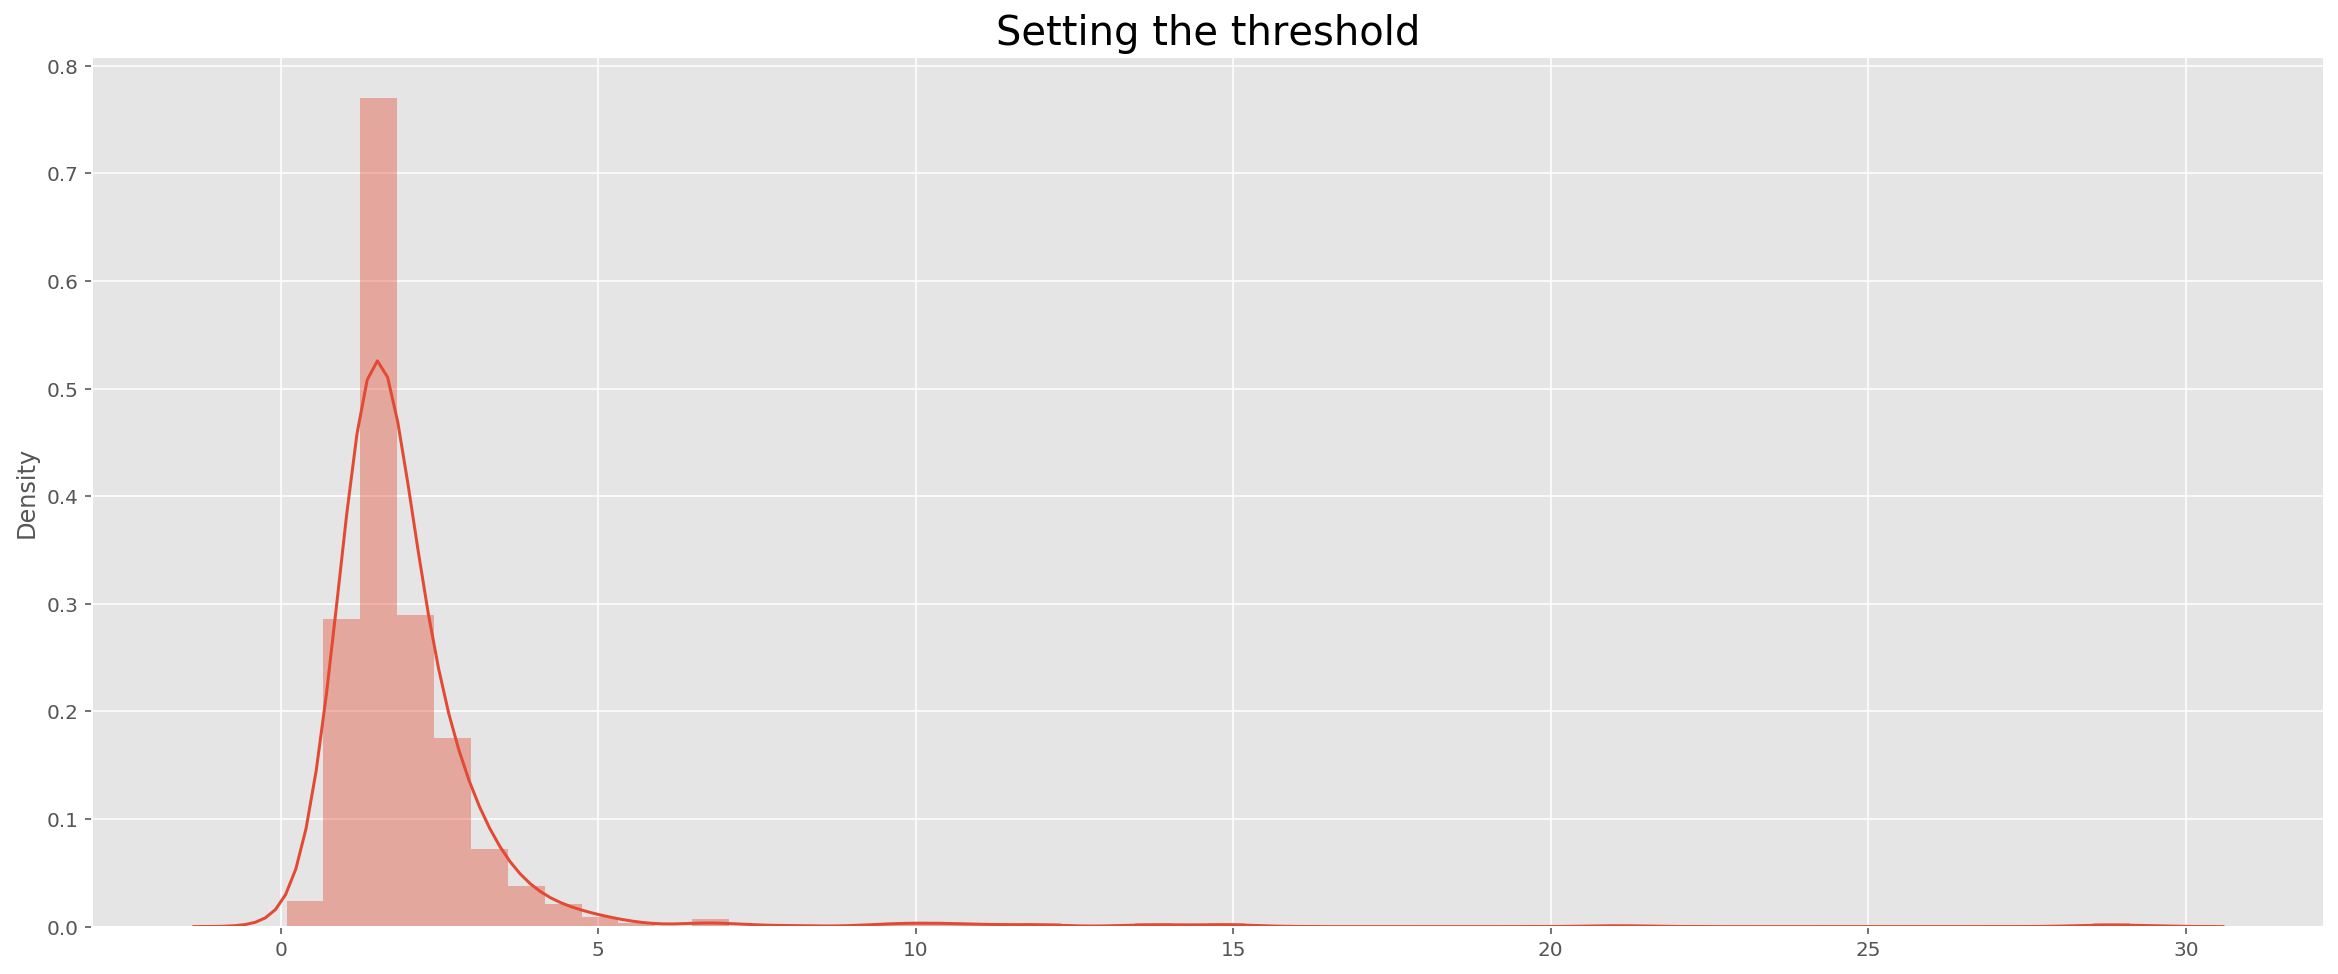

In [41]:
anomaly_real, anomaly_predictions, losses_test_anomaly = Calculate_RPL(model, sample_anomaly)
plt.figure(figsize = (20,8))
sns.distplot(losses_test_anomaly, bins=50, kde=True);
plt.title('Setting the threshold', fontsize = 20)
plt.show()

In [43]:
anomaly_count = sum(idx >= threshold for idx in losses_test_anomaly)
print(f'Anomaly count in prediction: {anomaly_count}/{len(losses_test_anomaly)}')

Anomaly count in prediction: 959/1000


In [44]:
def plot_prediction(data, model, title, ax):
  real, predictions, pred_losses = Calculate_RPL(model, [data])

  ax.plot(real[0].flatten(), label='true')
  ax.plot(predictions[0].flatten(), label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

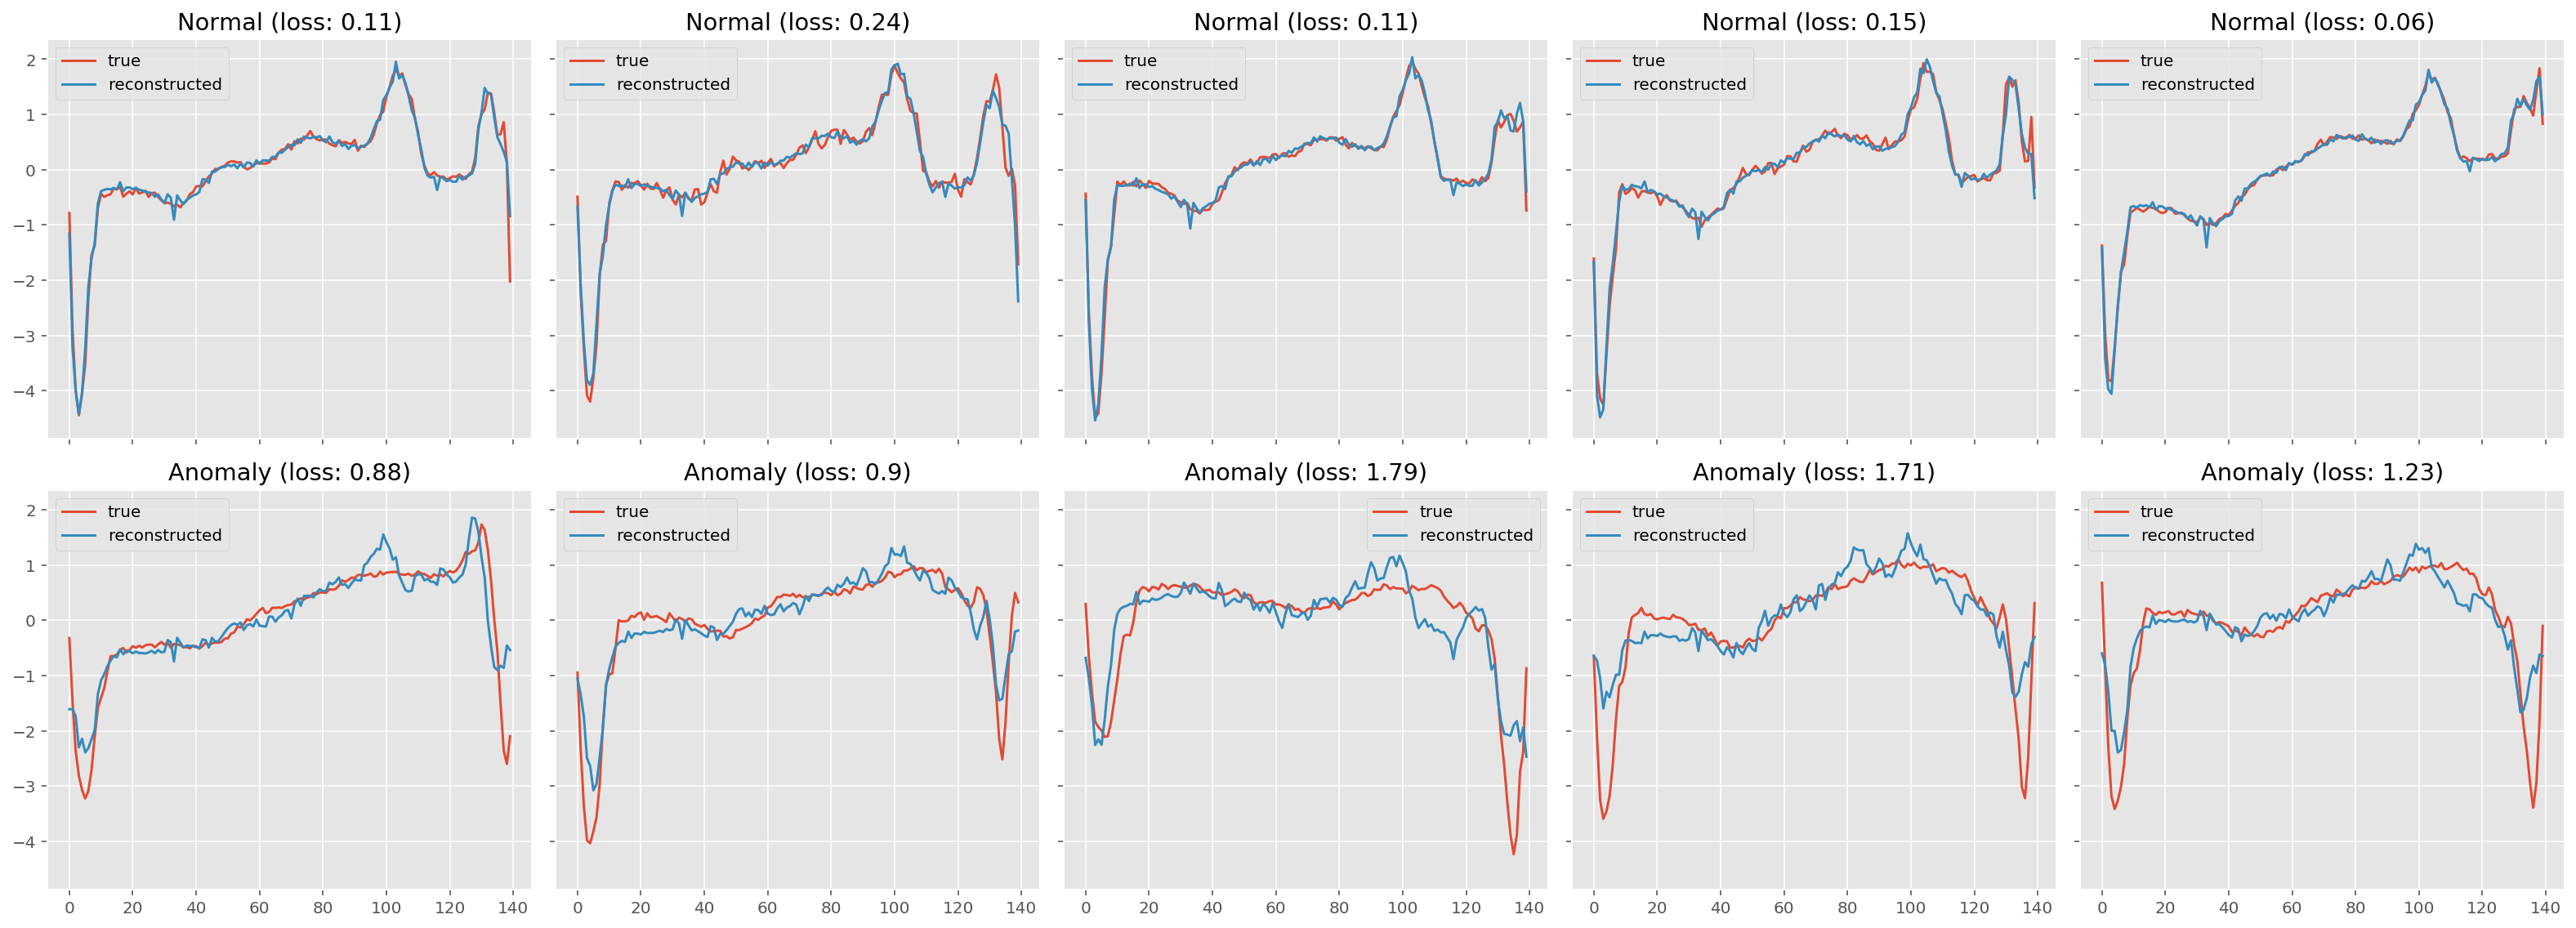

In [45]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=5,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:5]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:5]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

----

## Latent vector가 정상과 이상의 패턴을 잘 구분하는지 확인

In [46]:
with torch.no_grad():
    model.eval()
    for seq_true in train_loader:
        seq_true = seq_true.to(device)
        normal_latent_vector = model.get_encoder_outputs(seq_true)
        break

with torch.no_grad():
    model.eval()
    for seq_true in test_abnormal_loader:
        seq_true = seq_true.to(device)
        abnormal_latent_vector = model.get_encoder_outputs(seq_true)
        break

In [47]:
normal_latent_vector = normal_latent_vector.squeeze(1)
abnormal_latent_vector = abnormal_latent_vector.squeeze(1)

In [48]:
normal_latent_vector = pd.DataFrame(normal_latent_vector.detach().cpu().numpy())
normal_latent_vector['target'] = 0
abnormal_latent_vector = pd.DataFrame(abnormal_latent_vector.detach().cpu().numpy())
abnormal_latent_vector['target'] = 1

In [49]:
latent_df = pd.concat([normal_latent_vector, abnormal_latent_vector], axis=0)
latent_df.shape

(128, 129)

In [50]:
x = latent_df.drop('target', axis=1)
y = latent_df.target

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=seed)
z = tsne.fit_transform(x) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.000s...
[t-SNE] Computed neighbors for 128 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 0.691109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.935890
[t-SNE] KL divergence after 850 iterations: 0.158178


In [52]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

학습한 모델에 정상과 이상을 데이터를 64 batch씩 넣고, 이를 concat하여 t-SNE로 확인해본 결과 두 latent vector의 두 클래스 간에 차이가 존재하는 것을 알 수 있다.

[Text(0.5, 1.0, 'Latent_vector T-SNE projection')]

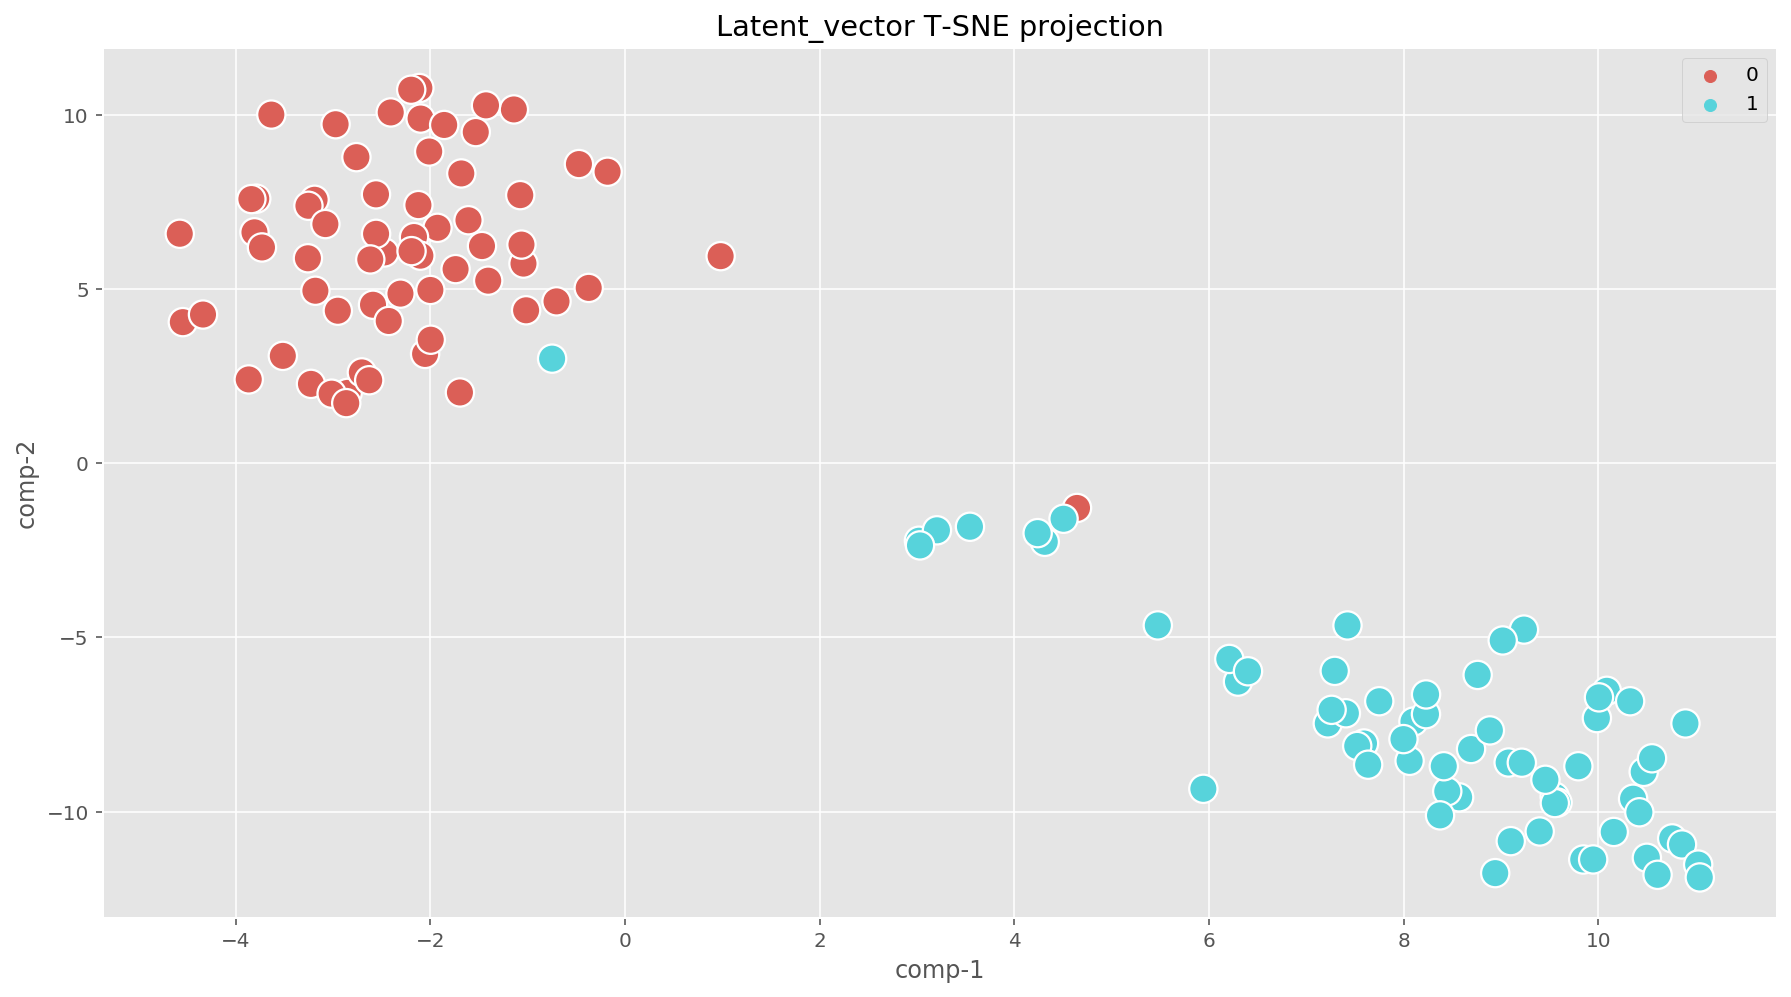

In [53]:
plt.figure(figsize = (15,8))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2), s = 200,
                data=df).set(title="Latent_vector T-SNE projection") 

----
## LSTM_AE의 인코더 구조를 활용한 forecasting

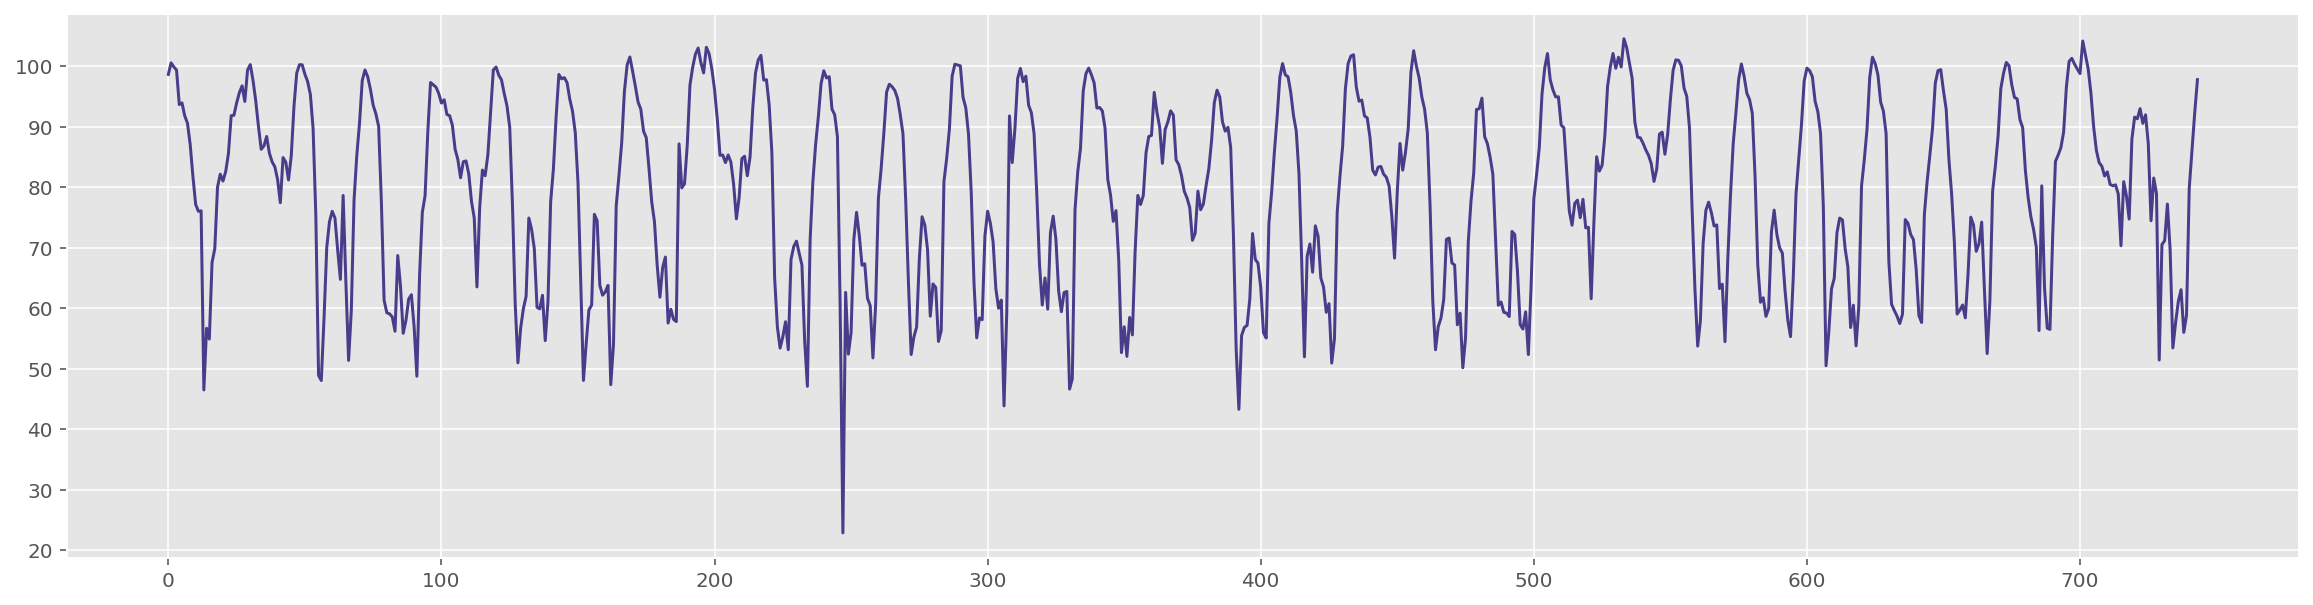

,Unnamed: 0,집계일시,평균속도
0,0,2021050100,98.63
1,1,2021050101,100.53
2,2,2021050102,99.86
3,3,2021050103,99.34
4,4,2021050104,93.64


In [160]:
rawdata = pd.read_csv("data/서인천IC-부평IC 평균속도.csv", encoding='CP949')
plt.figure(figsize=(20,5))
plt.plot(range(len(rawdata)), rawdata.loc[:,"평균속도"], color = 'darkslateblue')
plt.show()
rawdata.head()

In [85]:
model.encoder

Encoder(
  (LSTM1): LSTM(1, 256, batch_first=True)
  (LSTM2): LSTM(256, 128, batch_first=True)
)

In [92]:
len(test_normal_dataset)

145

In [96]:
sample = test_normal_dataset[0][:100]
test_normal_dataset[0][:100].shape

torch.Size([100, 1])

In [98]:
sample.shape

torch.Size([100, 1])

In [101]:
sample.unsqueeze(0).shape

torch.Size([1, 100, 1])

In [102]:
model.encoder(sample.unsqueeze(0))

RuntimeError: shape '[1, 140, 1]' is invalid for input of size 100

In [108]:
train_dataset[0].shape

torch.Size([140, 1])

In [106]:
en_out = model.encoder(train_dataset[0].to(device))

In [107]:
en_out.shape

torch.Size([1, 128])

In [67]:
train_dataset[0].shapea

torch.Size([140, 1])

In [69]:
for seq_true in train_dataset:
    seq_true = seq_true.to(device)
    break

In [71]:
train_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
2608,-0.919318,-3.014940,-3.384893,-3.981646,-3.828617,-3.234646,-1.804082,-1.140253,-0.655269,0.352905,...,1.403169,1.211733,1.471334,1.036322,0.224713,-0.791020,-0.645683,-0.361866,-0.113474,-1.988195
2075,-0.926007,-2.262675,-2.529812,-3.215854,-3.523628,-3.180778,-2.118943,-0.922453,-0.499912,-0.213151,...,0.355101,0.053107,-0.464577,-1.193877,-1.775372,-2.310713,-2.060028,-1.767327,-2.258348,-3.835663
1742,-1.127530,-2.892678,-4.039125,-4.997514,-4.388872,-2.979173,-1.857898,-1.661818,-0.880471,-0.187055,...,1.009903,1.913275,1.925496,2.236572,2.564307,1.803879,0.281025,-0.902882,-0.750354,-1.008387
150,1.005342,0.754930,-1.212065,-2.788717,-3.712512,-4.549913,-3.850799,-2.322095,-1.646850,-1.357239,...,-0.940618,-0.136767,0.269292,0.235111,0.581392,0.245466,0.296737,-0.834586,-0.924241,-0.625913
1330,-0.158517,-1.921215,-3.664709,-4.465341,-3.982826,-2.773979,-1.812134,-1.690512,-1.092731,-0.281107,...,1.191885,0.997710,0.857177,1.085414,1.075929,0.989721,1.051740,1.386680,2.041922,1.056013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.690359,-1.467353,-3.199391,-4.139882,-3.919458,-3.257177,-2.212842,-1.647828,-1.549699,-0.854778,...,0.647149,0.828539,0.632007,0.941910,1.202857,1.200362,1.405531,1.665317,2.379915,1.092986
56,-0.415819,-2.669981,-3.918828,-4.285928,-4.173037,-3.586434,-2.478273,-1.607117,-1.203307,-0.619225,...,1.013486,1.186335,1.486340,1.665004,1.433940,0.850226,0.403449,0.602889,1.137776,-0.144081
892,-1.134110,-3.059297,-3.866269,-4.304981,-4.065429,-3.514084,-2.591911,-1.595504,-1.336082,-1.125177,...,1.628770,1.519559,1.490954,1.239195,0.671416,-0.104259,-0.404891,-0.258704,0.117062,-1.139245
2366,-0.023095,-2.611266,-4.018630,-4.294045,-3.926619,-3.242963,-2.121322,-1.506411,-1.189799,-0.489618,...,1.010186,1.051499,1.413350,1.495256,1.300596,0.940931,1.217202,1.649980,0.919810,-1.965695


In [70]:
seq_true.shape

torch.Size([140, 1])

In [ ]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [73]:
sequences = train_df.astype(np.float32).to_numpy().tolist()

In [79]:
dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

In [80]:
n_seq, seq_len, n_features = torch.stack(dataset).shape
print(n_seq)
print(seq_len)
print(n_features)

2481
140
1


In [77]:
for s in sequences:
    a = torch.tensor(s).float().unsqueeze(1)
    break

In [78]:
a.shape

torch.Size([140])